# Imports

In [1]:
import sys
# sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/clasp')
sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/clasp/clasp')
import torch
from torch.utils.data import Dataset, DataLoader
import random
import time
from datetime import datetime
from functools import partial
import json
from tqdm import tqdm
import numpy as np

# Sampler

## Basic sampler

In [2]:
def basic_sampler(seq, sample_len):
    """
    Basic text sampler.
    Returns the first sample_len items.
    If sample_len is greater than the length of the seq, the seq is returned.
    """
    seq_len = len(seq)
    if seq_len > sample_len:
        return seq[:sample_len]
    else:
        return seq

## Basic random sampler

In [3]:
def basic_rand_sampler(seq, sample_len):
    """
    Basic random text sampler.
    If sample_len is greater than the length of the seq, the seq is returned.
    """
    seq_len   = len(seq)
    if seq_len > sample_len:
        start_idx = random.randint(0, min(seq_len,seq_len - sample_len))
        end_idx   = start_idx+sample_len
        return seq[start_idx:end_idx]
    else:
        return seq

# Tokenizer

## Basic aminoacid tokenizer

In [4]:
AA_VOCAB = "ACDEFGHIKLMNOPQRSTUVWY"
AA_DICT = {a: i for i, a in enumerate(AA_VOCAB)}

In [5]:
def basic_aa_tokenizer(seq, context_length, return_mask=True):
    """
    Maps a number between 0 and 21 to each 21 proteogenic aminoacids.
    Unknown char input gets mapped to 22.
    """
    seq_len = len(seq)
    seq_wrap = torch.zeros(context_length, dtype=torch.long) 
    seq_wrap[:seq_len] = torch.tensor([AA_DICT[a] if a in AA_VOCAB else 22 for a in seq], dtype=torch.long)
    if return_mask:
        mask = torch.zeros_like(seq_wrap, dtype=torch.bool)
        mask[0:seq_len] = True
        return seq_wrap, mask
    else:
        return seq_wrap

## Text tokenizer

In [6]:
from simple_tokenizer import tokenize

# Dataset

In [7]:
class CLASPDataset(Dataset):
    """
    Basic CLASP dataset that loads the preprocessed csv file into RAM.
        path: path to the csv file
    """
    def __init__(self, path, text_sampler, bioseq_sampler, text_tok, bioseq_tok):
        super().__init__()
        self.path = path

        tp = time.time()
        with open(path, "r") as reader:
            self.data = reader.readlines()
        print(f"Load data time: {time.time() - tp:.3f} s")

        self.cols = self.data.pop(0).split(",")
        self.len  = len(self.data)

        self.text_sampler   = text_sampler
        self.bioseq_sampler = bioseq_sampler

        self.text_tok   = text_tok
        self.bioseq_tok = bioseq_tok

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = self.data[idx][:-2] # without "\n"
        sample = sample.split(",")
        sample = [x for x in sample if len(x) > 0]

        text   = " ".join(sample[:-2])
        bioseq = sample[-1]

        text   = self.text_sampler(text)
        bioseq = self.bioseq_sampler(bioseq)
        
        print(text, len(text))
        print(bioseq, len(bioseq))

        text, text_mask = self.text_tok(text)
        bioseq, bioseq_mask = self.bioseq_tok(bioseq)

        return text, text_mask, bioseq, bioseq_mask

In [8]:
str_sampler = partial(basic_rand_sampler, sample_len=100)
text_tok    = partial(tokenize, context_length=120, return_mask=True)
bioseq_tok  = partial(basic_aa_tokenizer, context_length=120, return_mask=True)

In [9]:
ds = CLASPDataset(path="ANONYMOUS_ROOTDIR/develop/open-world/clasp/data/uniprot_100_reduced.csv",
                  text_sampler=str_sampler,
                  bioseq_sampler=str_sampler,
                  text_tok=text_tok,
                  bioseq_tok=bioseq_tok)

Load data time: 0.001 s


In [10]:
import sys
sys.path.append('ANONYMOUS_ROOTDIR/develop/open-world/clasp')
import torch
from torch import einsum
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from clasp import CLASP, Transformer, tokenize, basic_rand_sampler, basic_aa_tokenizer, CLASPDataset
from functools import partial
from collections import OrderedDict
import requests
import matplotlib.pyplot as plt

text_enc = Transformer(
    num_tokens = 49408,
    dim = 768,
    depth = 12,
    seq_len = 1024,
    reversible=True
)

bioseq_enc = Transformer(
    num_tokens = 23,
    dim = 768,
    depth = 12,
    seq_len = 512,
    sparse_attn = False,
    reversible=True
)

model = CLASP(
    text_encoder = text_enc,
    bioseq_encoder = bioseq_enc
)

################################## PRETRAIN ##################################
# path_weights = "ANONYMOUS_ROOTDIR/develop/open-world/clasp/run54_2021-09-01_06_26_29_step00070000.pt"
# ckpt = torch.load(path_weights, map_location="cpu")
# model.load_state_dict(ckpt)
################################## PRETRAIN ##################################

model.eval()

CLASP(
  (text_encoder): Transformer(
    (token_emb): Embedding(49408, 768)
    (pos_emb): SinuEmb()
    (rel_pos_emb): SinuEmb()
    (net): ReversibleSequence(
      (blocks): ModuleList(
        (0): ReversibleBlock(
          (f): Deterministic(
            (net): LayerScale(
              (fn): PreNorm(
                (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (fn): Attention(
                  (to_qkv): Linear(in_features=768, out_features=1536, bias=False)
                  (to_out): Sequential(
                    (0): Linear(in_features=512, out_features=768, bias=True)
                    (1): Dropout(p=0.0, inplace=False)
                  )
                )
              )
            )
          )
          (g): Deterministic(
            (net): LayerScale(
              (fn): PreNorm(
                (norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
                (fn): FeedForward(
                  (net): Sequential(
   

In [11]:
text_features, bioseq_features = [], []
with torch.no_grad():
    for text, text_mask, bioseq, bioseq_mask in tqdm(ds):
        bioseq = bioseq.unsqueeze(0)
        bioseq_mask = bioseq_mask.unsqueeze(0)

        text_out = model.text_encoder(text, mask=text_mask)
        bioseq_out = model.bioseq_encoder(bioseq, mask=bioseq_mask)
        text_out_norm = F.normalize(text_out, p=2, dim =-1)
        bioseq_out_norm = F.normalize(bioseq_out, p=2, dim =-1)

        text_features.append(text_out_norm)
        bioseq_features.append(bioseq_out_norm)

  0%|          | 0/99 [00:00<?, ?it/s]

M.; "Genome- and Community-Level Interaction Insights into Carbon Utilization and Element Cycling Fu 100
MVEALISDEAFIKGCAAIGAGLAVGLAGIGAGAGESGIGAAAVGAIAEDRGFLGLGLLFTVIPETIVIFGLVISFILMFA 80


  2%|▏         | 2/99 [00:00<00:26,  3.66it/s]

; 226 AA. Q51760; Q7LX17; SubName: Full=Glutaredoxin-like protein ; Pyrococcus furiosus. Archaea; Eu 100
DTPEGKELAKRYRIDRAPATTITQDGKDFGVRYFGLPAGHEFAAFLEDIVDVSREETNLMDETKQAIRNIDQDVRILVFVTPTCPYCPLAVRMAHKFAIE 100
ion and Element Cycling Functions of Hydrothermarchaeota in Hydrothermal Sediment.";  . NON_TER 1 /e 100
YERTITPFGNSAKLDAPKKYIGHRAYVIIVK 31


  3%|▎         | 3/99 [00:00<00:27,  3.52it/s]

iptional regulation in the hyperthermophilic archaeon Pyrococcus furiosus: coordinated expression of 100
VVEFVKFAAFVAYHLDDLVDMWSTMNEPNVVYNQGYINLRSGFPPGYLSFEAAEKAKFNLIQAHIGAYDAIKEYSEKSVGVIYAFAWHDPLAEEYKDEVE 100


  6%|▌         | 6/99 [00:01<00:22,  4.12it/s]

 J.Q.; Lopez-Cortes A.; "Methane production in hypersaline environments: Microbial diversity; struct 100
ESTIYGIENYEKYPTALEDHFGGSQRATVLSAAAGSAASLATGNANAGLSAWYLCMYLHKEALGRLGFFGFDLQDQCGATNVFSFQSDEGLPHELRGPNY 100
agment; Name=ef2 ; Halorubrum halodurans. Archaea; Euryarchaeota; Stenosarchaea group; Halobacteria; 100
PNPVDAQPRRVPRIWRGDPDSELAEGMQLVDEDGEVVFMVTDISMDPHAGEIATGRVFSGTLEKGQELYVSGTAGKNRIQSVGLFMGSEREEVEHVPAGN 100
Unreviewed; 160 AA. A8UQB8; SubName: Full=Methyl-coenzyme M reductase alpha ; Flags: Fragment; Name= 100
LYYNVDYINDKYDGAANKGVDNKVTASLDVVKDIATESTIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAGLSGWYLCMYVHKEALG 100


  7%|▋         | 7/99 [00:03<00:58,  1.56it/s]

lpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ABW73347.1" NON_TER 100
ASMDVIKDITTESTIYGLENYEKYPTTLEDHFGGSQRATSLSAAAGAATSIATGNGNAGLSAWYLCMYLHKEAHGRLGFFGYDLQDQCGATNVFSFQSDE 100


  8%|▊         | 8/99 [00:03<00:47,  1.91it/s]

F02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ATU81530.1" NON_TER 162 /evidence="ECO:0000313|EMBL:AT 100
LDNNVYYNVDYINDKYNGAATIGKDNKVKATLDVVKDIATESTLYGIETYEKFPTALEDHFGGSQRATVLAAAAGVAVALGTANANAGLSGWYLSMYLHK 100


  9%|▉         | 9/99 [00:04<00:47,  1.90it/s]

 ChEBI:CHEBI:58286; ChEBI:CHEBI:58411; ChEBI:CHEBI:58596; EC=2.8.4.1; Evidence= . DOMAIN 1..41 /note 100
TEVTLYGLEQYEKYPTTLEDHFGGSQRATVVSIAAGGATALATGHSNAGLSAWYLSMYLHKEAHGRLGFYGYDLQDQCGATNVFSIGSDEGCIGECRGAN 100


 10%|█         | 10/99 [00:04<00:46,  1.92it/s]

0313|EMBL:AFZ76936.1" NON_TER 162 /evidence="ECO:0000313|EMBL:AFZ76936.1" 3: Inferred from homology; 100
GVIQMGDILPARRARGPNEPGGIKFGHFADMIQADRKYPNDPARATLEVVGAGAMLFDQIWLGSYMSGGVGFTQYATAAYTDNILDDYTYYGMDYIKSKY 100


 11%|█         | 11/99 [00:05<00:53,  1.63it/s]

pear J.; Sahl J.; "Salinity controls the isotopic composition of methane and the methanogen communit 100
ILEDYTYWAADLVKDKFGGFAKMDPEINELMELVNKVNTYALSMYEEYPAAMEAHFGGSQRSTVCAAASAIAGAMATGSADVGVNCWYLSMVQHKERLGR 100


 13%|█▎        | 13/99 [00:07<00:55,  1.56it/s]

E ; uncultured Methanosarcina sp. Archaea; Euryarchaeota; Stenosarchaea group; Methanomicrobia; Meth 100
MAEYTMASFLQEAGKKTPVFVRFSTVVGFRGSADTVRDARGFATKFYTEDGNYDLVGNNIPVFFIQDAIKFPDLVHSIKPEPDDEMPQASAAHDTFWDFV 100
m:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ABW73324.1" NON_TER 160 /evidence="ECO:0000313|EMBL 100
TDNKVNATMDVVKDIATESTIYGIENYEKYPTALEDHFGGSQRATVLSAAAGSAASLATGNANAGLSAWYLSMYLHKEALGRLGFFGFDLQDQCGATNVF 100


 14%|█▍        | 14/99 [00:07<00:55,  1.54it/s]

 Unreviewed; 160 AA. A8USH6; SubName: Full=Methyl-coenzyme M reductase alpha ; Flags: Fragment; Name 100
EYINDKYDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSAWYLCTYLHKEGHGRLGFF 100


 16%|█▌        | 16/99 [00:08<00:35,  2.37it/s]

ame: Full=Methyl-coenzyme M reductase ; Flags: Fragment; Name=mcrA ; uncultured euryarchaeote. Archa 100
DNLYYNVDYINDKYDGAANKGVDNKVTASLDVVKDIATESTIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAGLSGWYLCMYVHKEA 100
nvironmental samples. NUCLEOTIDE SEQUENCE. Lee S.-H.; Kim S.-Y.; Kang H.; "Impact of elevated atmosp 100
DDILDNNLYYNVDYINQKYSDAAKVGKDNKVKATLDVVKDIATESTIFGIETYEKYPTALEDHFGGSQRATVLAAAAGCAVSLATANANAGLSGWYLSMY 100


 17%|█▋        | 17/99 [00:09<01:04,  1.26it/s]

zonia."; DOMAIN 1..117 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="E 100
YATAAYTDNILDDYTYYGMDYVKSKYGGAGKVPAKQDAVNDIATEVTLYGMEQYEQYPTALESHFGGSQRASVLAAAAGLSTSIGTGNSNAGLNAWYLSM 100


 18%|█▊        | 18/99 [00:10<01:13,  1.10it/s]

_TER 1 /evidence="ECO:0000313|EMBL:AAR24556.1" NON_TER 163 /evidence="ECO:0000313|EMBL:AAR24556.1" 4 100
IKDKYKVDWKNPNEKDKIKATQDNINDIATEVCLYGMEQYEQFPTMMEDHFGGSQRAGVLAAACGLSTSIATGNSNAGLNGWYLCMLLHKEGWSRLGFYG 100


 19%|█▉        | 19/99 [00:12<01:20,  1.00s/it]

59|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ACF16842.1" NON_TER 157 /evidence="ECO:000031 100
KDRYGGFCGVKADDYAKQMALADEISSYALEMYERYPAVMETHFGGSQRATVTAASTGIATAFATGVADNGLNTWYQSMLQHKERTGRLGFYGFDLQDQC 100


 20%|██        | 20/99 [00:12<01:03,  1.24it/s]

e I subunit A ; Flags: Fragment; Name=mcrA ; uncultured Methanosarcina sp. Archaea; Euryarchaeota; S 100
DDILDNNVYYDVDYINDKYNGAANVGKDNKIKATLDVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATSNANAGLSGWYLSMY 100


 21%|██        | 21/99 [00:13<01:07,  1.15it/s]

encing; and expression of the gene encoding extracellular alpha-amylase from Pyrococcus furiosus and 100
RDWLNWWGGWAVGEYWDTNVDALLSWAYESGAKVFDFPLYYKMDEAFDNNNIPALVYALQNGQTVVSRDPFKAVTFVANHDTDIIWNKYPAYAFILTYEG 100


 22%|██▏       | 22/99 [00:15<01:25,  1.11s/it]

rm manipulation of sulfate and salinity in a hypersaline microbial mat."; DOMAIN 1..119 /note="MCR_a 100
TQYATAPYCNNILDDNLYYNVDYINDKYDGAANKGVDNKVTASLDVVKDIATESTIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAG 100


 23%|██▎       | 23/99 [00:15<01:12,  1.05it/s]

ufert-Bebout L.; Bebout B.M.; "Shifts in methanogen community structure and function associated with 100
KDIATESTIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAGLSGWYLCMYVHKEALGRLGFFGYDLQGQCGATNVLSYQSDEGLALEL 100


 24%|██▍       | 24/99 [00:16<01:06,  1.13it/s]

crobiales archaeon. Archaea; Euryarchaeota; Stenosarchaea group; Methanomicrobia; Methanomicrobiales 100
RARGPNEPGGLAFGLFSDIIQANRKYPNDPAKASLEVVGAGTMLYDQIWLGSYMSGGVGFTQYATAAYTDNILDEFTYYGMDYIKDKYKVDWKNPSPKDR 100


 25%|██▌       | 25/99 [00:19<01:59,  1.61s/it]

8UQH2_9EURY Unreviewed; 155 AA. A8UQH2; SubName: Full=Methyl-coenzyme M reductase alpha ; Flags: Fra 100
VDYINDKYDGAANTGVDNKVEASMDVIKDITTESTIYGLENYEKYPTTLEDHFGGSQRATSLSAAAGAATSIATGNGNAGLSAWYLCMYLHKEAHGRLGF 100


 27%|██▋       | 27/99 [00:26<02:43,  2.27s/it]

the alpha Mcr of the methanogenic Archaea from the anoxic region of Tucurui Lake; in Eastern Brazili 100
NILDDYTSYGVDYVKKKYGGIAKAKATQEIVNDIATEVTLYGMEQYEEFPTALESHFGGSQRATVLAAAAGVSAALATANSNAGLNGWYLSMLLHKDGWS 100
EOTIDE SEQUENCE. Castro H.; Ogram A.; Reddy K.R.; "Phylogenetic characterization of methanogenic ass 100
PNTMDSVLDVASEVTFYALEQFEDYPALLETIFGGSQRASIVAAGAACSTGFATGNAQTALSGWYLSMYLHKEQHARLGFYGYDLQDQCGATNVFSVRGD 100


 29%|██▉       | 29/99 [00:27<01:28,  1.26s/it]

; Bebout B.M.; "Shifts in methanogen community structure and function associated with long-term mani 100
DDRVKASQEVVNDLATEVCLNANEQYEQYPTLMEDHFGGSQRAGVNAAACGLTCSIGTGNSNAGLNGWYLSMLVHKENWSRLGFFGYDLQDQCGSANSLS 100
glades."; DOMAIN 1..105 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence=" 100
VLDDFTYYGQEYVEDKFGMTEAPNTMETVLDVGSEVTFYALEQFEDYPALLETIFGGSQRASIVAAAAGCATGFATGNAQTGLSAWYLSMYLHKEQHSRL 100
vidence="ECO:0000313|EMBL:ABG48742.1" NON_TER 144 /evidence="ECO:0000313|EMBL:ABG48742.1" 4: Predict 100
VTLYGMEQYEAYPTLLEDHFGGSQRASVLAAASGITAAIASGHSQVGLAAWYLSMLLHKEGWGRLGFFGYDLQDQCGPTNVFSYQSDEGNPVEMRGANYP 100


 31%|███▏      | 31/99 [00:27<00:54,  1.25it/s]

crA ; uncultured euryarchaeote. Archaea; Euryarchaeota; environmental samples. NUCLEOTIDE SEQUENCE.  100
KQAAGEAATGDFAYAAKHAEVVHMGTALPQRRARGENEPGGIPFGYLADICQSSRVNPDDPAKVTLDVVASGAMLYDQIWLGSYMSGGVGFTQYATAAYT 100


 32%|███▏      | 32/99 [00:27<00:44,  1.49it/s]

; Name=mcrA ; uncultured euryarchaeote. Archaea; Euryarchaeota; environmental samples. NUCLEOTIDE SE 100
ANPSPDDRVKASQEVVNDLATEVCLNANEQYEQYPTLMEDHFGGSQRAGVNAAACGLTCSIGTGNSNAGLNGWYLSMLVHKENWSRLGFFGYDLQDQCGS 100


 33%|███▎      | 33/99 [00:28<00:43,  1.51it/s]

ic composition of methane and the methanogen community structure in a hypersaline ecosystem."; DOMAI 100
DYINDKYDGAANTGVDNKVEASMDVIKDITTESTIYGLENYEKYPTTLEDHFGGSQRATSLSAAAGAATSIATGNGNAGLSAWYLCMYLHKEAHGRLGFF 100


 34%|███▍      | 34/99 [00:28<00:39,  1.64it/s]

Y Unreviewed; 159 AA. A8UQH6; SubName: Full=Methyl-coenzyme M reductase alpha ; Flags: Fragment; Nam 100
STIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAGLSGWYLCMYVHKEALGRLGFFGYDLQDQCGATNVLSYQSDEGLALELRGPNYP 100
idence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:AFI71026.1" NON_TER 155 /evi 100
LCQAEASSDVVRDIASEVTLYGLEQYEIPAALEDHFGGSQRAAVLAAGAGCSVAFATANSNAGVNGWYLSQLLHKEGHSRLGFYGYDLQDQCGSSNSLSV 100


 36%|███▋      | 36/99 [00:29<00:30,  2.08it/s]

I:58596; EC=2.8.4.1; Evidence= . DOMAIN 1..41 /note="MCR_alpha_N" /evidence="ECO:0000259|Pfam:PF0274 100
DIATEVTLYGMEQYEQFPSLLEDHFGGSQRASVLAAAAGLTCSMATANSNAGLNGWYLSMLLHKEGWSRLGFYGYDLQDQCGSANCMAIRSDEGLITELR 100


 38%|███▊      | 38/99 [00:29<00:25,  2.41it/s]

ylthiotransferase ; Flags: Fragment; Name=mcrA ; uncultured Methanosarcinales archaeon. Archaea; Eur 100
HMCAGEAAVGELAFTAKHAGLVEMGDMIPARRARGPNEPGGLSFGHMADIVQTGRKTPDDPVNVNLQIASAATMLYDQIWLGGYMSGGVGFTMYATPAYT 100
; Flags: Fragment; Name=mcrA ; uncultured Methanosarcina sp. Archaea; Euryarchaeota; Stenosarchaea g 100
DNNTYYNVDYINDKYNGAANVGKDNKVKATLDVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATSNANAGLSGWYLSMYLHKE 100


 39%|███▉      | 39/99 [00:30<00:25,  2.34it/s]

EURY Unreviewed; 119 AA. A0A023W4M2; SubName: Full=Methyl-coenzyme M reductase I subunit A ; Flags:  100
TDDILDNNTYYNVDYINDKYNGAANVGKDNKVKATLDVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVSTALATSNANAGLSGWYLSM 100


 40%|████      | 40/99 [00:30<00:25,  2.29it/s]

IF0_9EURY Unreviewed; 158 AA. A2TIF0; SubName: Full=Methyl-coenzyme M reductase ; Flags: Fragment; N 100
DRVKASQEVVNDLATEVCLNANEQYEQYPTLMEDHFGGSQRAGVNAAACGLTCSIGTGNSNAGLNGWYLSMLVHKENWSRLGFFGYDLQDQCGSANSLSV 100


 41%|████▏     | 41/99 [00:32<00:41,  1.39it/s]

 261 AA. A0A1L5YK45; RecName: Full=Coenzyme-B sulfoethylthiotransferase ; Flags: Fragment; Name=mcrA 100
ASLEVVAAGTMLFDQIWLGSYMSGGVGFTQYATAAYTDNILDEYTYYGMDLIKSKYKVDWKNPNPKDKVKCTQEILNEIATEVALNAMENYEMFPTALED 100


 43%|████▎     | 43/99 [00:33<00:40,  1.38it/s]

; "Methanogenenic communities from Huixian karst wetland; Guilin; China."; -!- CATALYTIC ACTIVITY: R 100
NDILDDYLYWGYDYARKKYGKLGSAKATIETVKDIGTETTLYGLEAYEKYPTTLEDHFGGSQRATVLALAAGSATAAATGHSNAGLSAWYLSMYLHKEAW 100
A0A1L5YK27_9EURY Unreviewed; 254 AA. A0A1L5YK27; RecName: Full=Coenzyme-B sulfoethylthiotransferase  100
SFGHMCDIVQTSRKTPDDPCNVVLQLASAASMLYDQIWLGGYMSGGVGFTMYATPAYTNDILDDYVYWGADYCQKKYGKPGSAKATIETVKDIGTEVTLY 100


 44%|████▍     | 44/99 [00:34<00:37,  1.46it/s]

8411; ChEBI:CHEBI:58596; EC=2.8.4.1; Evidence= . DOMAIN 2..41 /note="MCR_alpha_N" /evidence="ECO:000 100
ATGEFAFMAKHASVIMMSNYMPVRRARAHNEPGGMPLGICDDCTRSPALFPNDPVRAELEAIAIAADVYDQLWFGTYMSGGVGFTQYASATYTDNILEDF 100


 45%|████▌     | 45/99 [00:34<00:30,  1.79it/s]

"; -!- CATALYTIC ACTIVITY: Reaction=coenzyme B + methyl-coenzyme M = coenzyme M-coenzyme B heterodis 100
MCAGEAAVADLAFAAKHAGVIQMADILPARRARGPNEPGGIKFGHFCDMVQSDRKYPNDPVRSSLEIVAAGTMLFDQIWLGSYMSGGVGFTQYATAAYTD 100


 46%|████▋     | 46/99 [00:35<00:26,  2.03it/s]

ronmental samples. NUCLEOTIDE SEQUENCE. NUCLEOTIDE SEQUENCE. Bebout B.; Chanton J.; Kelley C.; Tazaz 100
YDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSAWYLCMYLHKEGHGRLGFFGFDLQD 100


 47%|████▋     | 47/99 [00:36<00:37,  1.38it/s]

N 2..113 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMB 100
TVDDNLYADTEYGWDTYGTSIGNVKAPTLDIIKDIGTWGALYGLELYENYPTALEDHFGGSQRATVISTATRAACAITTGNSNAGLSAWYLSMYLHKEAH 100


 48%|████▊     | 48/99 [00:39<01:16,  1.49s/it]

|Pfam:PF02745" DOMAIN 71..163 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evid 100
AFAAKHAGVIQMGDILPARRARGPNEPGGIKFGHFADMIQADRKYPNDPARATLEVVGAGAMLFDQIWLGSYMSGGVGFTQYATAAYTDNILDDYTYYGM 100


 49%|████▉     | 49/99 [00:40<01:07,  1.35s/it]

ogenesis in hypersaline environments - Analogs for ancient Mars?"; DOMAIN 1..123 /note="MCR_alpha" / 100
NDKYDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSAWYLCMYLHKEGHGRLGFFGFD 100


 51%|█████     | 50/99 [00:43<01:21,  1.66s/it]

lora change the community composition of methanogens in Chongming wetland."; DOMAIN 1..117 /note="MC 100
IAKAKSTQEVVSDIATEVNLYGMEQYETYPTALESHFGGSQRASVLAAASGISCAMATANSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANSMS 100


 52%|█████▏    | 51/99 [00:49<02:31,  3.16s/it]

.A.; Prufert-Bebout L.; Bebout B.M.; "Shifts in methanogen community structure and function associat 100
VKASQEVVNDLATEVCINANEQYEQFPTLMEDHFGGSQRAGVNAAACGLTCSIGTGNSNAGLNGWYLSMLMHKENWSRLGFFGYDLQDQCGSTNSLSVRP 100


 54%|█████▎    | 53/99 [00:52<01:38,  2.15s/it]

p; Methanomicrobia; Methanomicrobiales; environmental samples. NUCLEOTIDE SEQUENCE. Prasanna Kumar C 100
VADLAFAAKHAGVIQMGDILPARRARGPNEPGGIKFGHFADMIQADRKYPNDPARATLEVVGAGAMLFDQIWLGSYMSGGVGFTQYATAAYTDNILDDYT 100
oup; Methanomicrobia; Methanomicrobiales; environmental samples. NUCLEOTIDE SEQUENCE. Chen Y.; "Meth 100
PVRANLEVVAAGAMLFDQIWLGSYMSGGVGFTQYATAAYTDNILDDYCEYGLDYIKKKHGGIAKAKPTQEVVSDIATEVNLYGMEQYETYPTALESHFGG 100


 56%|█████▌    | 55/99 [00:52<00:48,  1.11s/it]

:RHEA:12532; ChEBI:CHEBI:16183; ChEBI:CHEBI:58286; ChEBI:CHEBI:58411; ChEBI:CHEBI:58596; EC=2.8.4.1; 100
DYTYYGMDLIKDKYKVDWRNPNAKDRLKPTQDLVNELATEVTLNAMEQYEQFPTLMEDHFGGSQRAGVIAAASGLTCGIATANSNAGLNGWYMSMLAHKE 100
:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:AHX83334.1" NON_TER 118 /evidence="ECO:0000313|EMBL: 100
DNNTYYNVDYINDKYNGAAKVGKDNKIKATLEVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATGNANAGLSGWYLSMYLHKE 100


 57%|█████▋    | 56/99 [00:52<00:34,  1.24it/s]

hEBI:CHEBI:16183; ChEBI:CHEBI:58286; ChEBI:CHEBI:58411; ChEBI:CHEBI:58596; EC=2.8.4.1; Evidence= . D 100
LKFGLFSDIVQTDRKYPNDPVKSSLEVVAAGTMLFDQIWLGSYMSGGVGFTQYATAAYTDNVLDDYCYYGQDYVKDKYKGWTKAPATQAAVNDIATEVTL 100
59|Pfam:PF02745" DOMAIN 89..214 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /ev 100
FAAKHAALVEMADILPARRARGPNEPGGLPFGYLADIVQTNRKYPDDPVKSSLEVVASGCMLYDQIWLGSYMSGGVGFTQYATAAYTDDILDDFTYYGYD 100


 59%|█████▊    | 58/99 [00:53<00:20,  1.97it/s]

122 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ADW 100
YTNNILDDNLYYDVEYINDKYDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSAWYLC 100


 60%|█████▉    | 59/99 [00:53<00:22,  1.80it/s]

!- CATALYTIC ACTIVITY: Reaction=coenzyme B + methyl-coenzyme M = coenzyme M-coenzyme B heterodisulfi 100
NMCAGEAAVADLSFAAKHAALVSMGEMLPARRARGPNEPGGLSFGHLSDIVQTSRTVTDDPAKVALEVVGAGCMLYDQIWLGSYMSGGVGFTQYATAAYT 100


 61%|██████    | 60/99 [00:54<00:19,  2.04it/s]

J.; Sahl J.; "Salinity controls the isotopic composition of methane and the methanogen community str 100
AAYTNNILDDNLYYDVEYINDKYDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSAWY 100


 63%|██████▎   | 62/99 [00:54<00:14,  2.56it/s]

.; Spear J.; Sahl J.; "Salinity controls the isotopic composition of methane and the methanogen comm 100
DGAANKGTDNKIEANLDVVKDIATESTIYGIENYEKYPTTLEDHFGGSQRATSLSAAAGSAVSIATGNGNAGLSGWYLSMYLHKEALGRLGFFGFDLQDQ 100
 "The invasion of Spartina alterniflora change the community composition of methanogens in Chongming 100
VKATLDVVKDIATESTLYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATANANAGLSGWYLSMYLHKEAWGRLGFFGYDLQDQCGATNVLSYQG 100


 64%|██████▎   | 63/99 [00:54<00:11,  3.23it/s]

tsyurbenko O.R.; Conrad R.; Chansiri K.; "Methanogenesis in Mae Wong Hot spring in Thailand."; -!- C 100
VGFTQYATAAYTDNILDDYTAYGVDYVKKKYGGLAKTKPTQDVVNDIASEVTLYGMEQYEEFPTALESHFGGSQRATVLAAASGVTTALATANSNAGLNG 100
CO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:ABW73429.1" NON_TER 154 /evidence="EC 100
AAYTDNILEDYTYWAADLVKDKFGGFAKMDPEINELMELVNKVNTYALSMYEEYPAAMEAHFGGSQRSTVCAAASAIAGAMATGSADVGVNCWYLSMVQH 100


 66%|██████▌   | 65/99 [00:55<00:09,  3.68it/s]

t A.D.; "Community composition and density of methanogens in the foregut of the Tammar wallaby (Macr 100
DEISSYALEMYERYPAVMETHFGGSQRATVTAASTGIATAFATGVADNGLNTWYQSMLQHKERTGRLGFYGFDLQDQCGSANSYSYRSDEGLPMELRGPN 100


 68%|██████▊   | 67/99 [00:56<00:08,  3.57it/s]

9|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:APP91475.1" NON_TER 254 /evidence="ECO:0000313 100
VKDIGTEVTLYGLESYEKYPTALEDHFGGSQRATVLAIAAGTSTSLATGHSNAGLSAWYLSMYLHKEAHGRLGFYGYDLQDQCGATNVFSIASDEGCIGE 100
Y: Reaction=coenzyme B + methyl-coenzyme M = coenzyme M-coenzyme B heterodisulfide + methane; Xref=R 100
MSFIGAYKMCAGEAAVADLAFAAKHAGVIQMADILPARRARGPNEPGGIKFGHFCDMIQGDRKYPNDPVRANLEVVAAGAMLFDQIWLGSYMSGGVGFTQ 100


 70%|██████▉   | 69/99 [00:56<00:09,  3.00it/s]

the methanogen community structure in a hypersaline ecosystem."; DOMAIN 1..117 /note="MCR_alpha" /ev 100
QYATAAYTDNILEDYTYWAADLVKDKFGGFAKMDPEINELMELVNKVNTYALSMYEEYPAAMEAHFGGSQRSTVCAAASAIAGAMATGSADVGVNCWYLS 100
 AA. Q6L771; RecName: Full=Coenzyme-B sulfoethylthiotransferase ; Flags: Fragment; Name=mcrA ; uncul 100
SMGEMLPARRARGPNEPGGLSFGHLSDIIQTSRTSQDPAKIALEVVGAGCMLYDQIWLGSYMSGGVGFTQYATAAYTDDILDNNVYYDVDYINDKYNGAA 100


 72%|███████▏  | 71/99 [00:57<00:09,  3.00it/s]

uctase alpha ; Flags: Fragment; Name=mcrA ; uncultured euryarchaeote. Archaea; Euryarchaeota; enviro 100
ATAAYTNNILDDNLYYDVEYINDKYDGAADKGIDNKVAPSMDVIKDIATESTLYGLENYEKYPVALEDHFGGSQRATVLSAAAGSAGSLATGNANAGLSA 100
al samples. NUCLEOTIDE SEQUENCE. Munk B.; Lebuhn M.; "Process diagnosis using methanogenic Archaea i 100
TDDILDNNTYYNVDYINDKYNGAANVGKDNKVKATLDVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATSNANAGLSGWYLSM 100
na alterniflora change the community composition of methanogens in Chongming wetland."; DOMAIN 1..11 100
VAGEVTLYSLEQYDEYPALLEDHFGGSQRAAVAAAASGIGVCMATGNSNAGVNGWYLSQVLHKEYHSRLGFYGYGLQDQCGASNSLAIRNDEAAPLELRG 100


 74%|███████▎  | 73/99 [00:58<00:08,  2.93it/s]

hanogens in Chongming wetland."; DOMAIN 1..124 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249 100
NDIATEVTLNGMEQYEQFPTAMEDHFGGSQRAAVLAAASGISTAIATANSNAGLNGWYLSMLLHKEGWSRLGFFGYDLQDQCGSTNSLSVRPDEGCIGEF 100


 75%|███████▍  | 74/99 [01:00<00:17,  1.44it/s]

Flags: Fragment; uncultured euryarchaeote. Archaea; Euryarchaeota; environmental samples. NUCLEOTIDE 100
DVDYINDKYNGAANLGTDNKVKATLDVVKDIATESTLYGIETYEKFPTALEDHFGGSQRATVLAAAAGVAVALGTANANAGLSGWYLSMYLHKEAWGRLG 100


 76%|███████▌  | 75/99 [01:01<00:18,  1.30it/s]

oenzyme M reductase ; Flags: Fragment; uncultured euryarchaeote. Archaea; Euryarchaeota; environment 100
GIGKAKSTQEAVTDIATEVNLYGMEQYEQYPTALESHFGGSQRASVLAAASGISCSLATANSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANSM 100


 77%|███████▋  | 76/99 [01:01<00:15,  1.53it/s]

; DOMAIN 1..123 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000 100
ATLDVVKDIATESTLYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATANANAGLSGWYLSMYLHKEAWGRLGFFGYDLQDQCGATNVLSYQGDE 100


 78%|███████▊  | 77/99 [01:02<00:15,  1.38it/s]

n-rich substrates on biogas production and on the methanogenic community under mesophilic and thermo 100
DNNTYYNVDYINDKYNGAAKVGKDNKIKATLEVVKDIATESTIYGIETYEKFPTALEDHFGGSQRATVLAAAAGVATALATGNANAGLSGWYLSMYLHKE 100


 79%|███████▉  | 78/99 [01:02<00:12,  1.73it/s]

wetland."; DOMAIN 1..124 /note="MCR_alpha" /evidence="ECO:0000259|Pfam:PF02249" NON_TER 1 /evidence= 100
YGMDYLKDKYGFDYKNPDPKATIAPTQEVVNDLATEVNLNGMEQYEQYPTAMEDHFGGSQRAGVLAAACGLTCSIGTGNSNAGLNGWYLSMLMHKEGWSR 100


 80%|███████▉  | 79/99 [01:03<00:11,  1.77it/s]

A0A2D3I2J3; SubName: Full=Methyl coenzyme M reductase ; Flags: Fragment; uncultured euryarchaeote. A 100
EVNLNAMEQYEQYPTMMEDHFGGSQRAGVMAAACGLSTSIATGNSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANSLSMEPDRGLIGELRGPNY 100


 81%|████████  | 80/99 [01:03<00:10,  1.75it/s]

tion water from low temperature petroleum reservoir."; DOMAIN 1..113 /note="MCR_alpha" /evidence="EC 100
DNILDEFTYYGMDYIKDKYKVDWQNPNPNDKVKPTQEVVNDIATEVNLNGMEQYETYPTMLEDHFGGSQRASVLAAASGISTSIATGNSNAGLNGWYLSM 100


 82%|████████▏ | 81/99 [01:04<00:12,  1.50it/s]

:0000259|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:QAB43508.1" NON_TER 145 /evidence="ECO: 100
NPNAKDKVKPTQEVVNDIATEVNLNGMEQYEQYPTMMEDHFGGSQRAGVLAAACGLSTAIATGHSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSA 100


 83%|████████▎ | 82/99 [01:05<00:12,  1.31it/s]

ol culture in production water from low temperature petroleum reservoir-mcrA."; "Methanogenic biodeg 100
LAEAPNTMDTVLDVASEVTFYGLEQYEDYPSLLETQFGGSQRAAVAAAAAGCSTGFATGNSQTALSGWYLSMYLHKEQHARLGFYGYDLQDQCGAANVFA 100


 84%|████████▍ | 83/99 [01:06<00:10,  1.46it/s]

production water from low temperature petroleum reservoir."; DOMAIN 1..113 /note="MCR_alpha" /eviden 100
PNDKVKPTQEVVNDIATEVNLNGMEQYEQYPTMMEDHFGGSQRAGVLAAACGLSTSIATGHSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANTL 100


 85%|████████▍ | 84/99 [01:07<00:11,  1.28it/s]

rom low temperature petroleum reservoir with iron oxide-mcrA."; DOMAIN 1..113 /note="MCR_alpha" /evi 100
KDRVKASQDVVNDIATEVALNGMEQYEQFPTLMEDHFGGSQRAGVLAAACGLSTSIATGNSNAGLNAWYLCMLLHKEGWSRLGFFGYDLQDQCGSTNSLS 100


 86%|████████▌ | 85/99 [01:08<00:14,  1.03s/it]

9" NON_TER 1 /evidence="ECO:0000313|EMBL:QAB43520.1" NON_TER 145 /evidence="ECO:0000313|EMBL:QAB4352 100
SPSDKVKPTQEIVNDLATEVTLNAMEQYEQFPTMMEDHFGGSQRAGVIAAASGLTTSITTGNSNAGLNGWYLSMLLHKDGWSRLGFFGYDLQDQCGSANS 100


 87%|████████▋ | 86/99 [01:11<00:19,  1.51s/it]

nreviewed; 145 AA. A0A410HW79; SubName: Full=Methyl-coenzyme M reductase alpha subunit ; Flags: Frag 100
IKDKYKVDWQNPNAKDKVKPTQEIVNDIATEVNLNGMEQYEQYPTMMEDHFGGSQRAGVLAAACGLSTSIATGHSNAGLNGWYLSMLMHKEGWSRLGFFG 100


 88%|████████▊ | 87/99 [01:13<00:19,  1.65s/it]

 petroleum reservoir-mcrA."; "Methanogenic biodegradation of C9-C12 in production water from low tem 100
KPTQEIVNDIATEVNLNGMEQYEQYPTMMEDHFGGSQRAGVLAAACGLSTSIATGHSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANTLSVRPD 100


 89%|████████▉ | 88/99 [01:18<00:30,  2.80s/it]

9|Pfam:PF02249" NON_TER 1 /evidence="ECO:0000313|EMBL:QAB43437.1" NON_TER 145 /evidence="ECO:0000313 100
NPNAKDKVKPTQEIVNDIATEVNLNGMEQYEQYPTMMEDHFGGSQRAGVLAAACGLSTAIATGHSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSA 100


 92%|█████████▏| 91/99 [01:23<00:14,  1.78s/it]

occi; Thermococcales; Thermococcaceae; Pyrococcus. NUCLEOTIDE SEQUENCE. NUCLEOTIDE SEQUENCE. Diruggi 100
WAAIDVESKEVLAVWITTVRNWWVARDFILVVLKSCEGQPVFLVDRASWYKSAFKSLRLGYLHVTFGPRNSVERWFRTLKERTKRFWNNFRGKDWRRVHR 100
petroleum reservoir-mcrA."; "Methanogenic biodegradation of C9-C12 in production water from low temp 100
FSYYGVDYANDKFGGFAKAPATIDVAKELATEVTLYGIEQYEAFPTLLEDHFGGSQRAAVLAAASGITSAIATGHSQIGLAGWYLSMLLHKEAWGRLGFF 100
nd function associated with long-term manipulation of sulfate and salinity in a hypersaline microbia 100
GMDYLKDKYGFDYTNPSPEQILKPTQEVVNDLATEVTINALEQYEQFPTLMEDHFGGSQRAGVTAAASGLTCSISTGNSNAGLNGWYLSMIVHKDAWSRL 100


 94%|█████████▍| 93/99 [01:23<00:06,  1.04s/it]

93_01842 ; Euryarchaeota archaeon ADurb.BinA087. Archaea; Euryarchaeota. NUCLEOTIDE SEQUENCE [LARGE  100
MQGSPEGRSSAFDSSVISSTSRYRSSQSRVLLSIIFSSLFFSAFRHRYWGCDKVTSMERKKKSSGTWRVWLSWMRTRELGTTSPVSYLEIAIALIPISFP 100
.; Liu W.-T.; "Delving into the versatile metabolic prowess of the omnipresent phylum Bacteroidetes. 100
MAARVAGMQERNTMEQLVVTREAVEAYERRTGFVGIGEFFLRKGLFVLKEGETCRK 56


 95%|█████████▍| 94/99 [01:23<00:03,  1.28it/s]

A0A410HWW4; SubName: Full=Methyl-coenzyme M reductase alpha subunit ; Flags: Fragment; Name=mcrA ; m 100
TYYGKEYVEDKYGLAEAPNTMDTVLDVASEVTFYGLEQYEDYPSLLETQFGGSQRAAVAAAAAGCSTGFATGNSQTALSGWYLSMYLHKEQHARLGFYGY 100


 96%|█████████▌| 95/99 [01:24<00:03,  1.27it/s]

onado J.Q.; Lopez-Cortes A.; "Methane production in hypersaline environments: Microbial diversity; s 100
ASMDVIKDITTESTIYGLENYEKYPTTLEDHFGGSQRATSLSAAAGSAASIATGNGNAGLSSWYLCMYLHKEAHGRLGFFGYDLQDQCGATNVFSFQSDE 100


 97%|█████████▋| 96/99 [01:24<00:01,  1.55it/s]

and sinks in Lake Kivu."; -!- CATALYTIC ACTIVITY: Reaction=coenzyme B + methyl-coenzyme M = coenzyme 100
YGVDYVKKKYGDLSKVKATQETVNDIASEVTLYGMEQYEEFPTALESHFGGSQRATVLAAASGVTTSLATANSNAGLNAWYMSMLLHKEGWSRLGFYGFD 100


100%|██████████| 99/99 [01:25<00:00,  1.16it/s]

te and salinity in a hypersaline microbial mat."; DOMAIN 1..119 /note="MCR_alpha" /evidence="ECO:000 100
NVDYINDKYDGAANKGVDYKVTASLDVVKDIATESTIYGIENYEKYPTTLEDHFGGSQRGTSLSAAAGSAVAIATGNGNAGLSGWYLCMYVHKEALGRLG 100
=Methyl coenzyme M reductase ; Flags: Fragment; uncultured euryarchaeote. Archaea; Euryarchaeota; en 100
TQEIVNDLTTEVNLNAMEQYEQYPTLMEDHFGGSQRAGVMAAACGLTCSIGTGNSNAGLNGWYLSMLMHKEGWSRLGFFGYDLQDQCGSANSLSMEPDRG 100


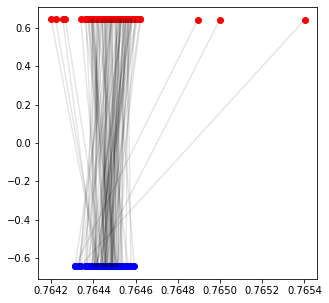

In [12]:
# Use PCA to reduce dimensionality
all_img_features = torch.cat(bioseq_features, dim=0)
all_text_features = torch.cat(text_features, dim=0)

np.save('features_clasp_random.npy', [all_img_features.numpy(), all_text_features.numpy()])

def svd(X, n_components=2):
    # using SVD to compute eigenvectors and eigenvalues
    # M = np.mean(X, axis=0)
    # X = X - M
    U, S, Vt = np.linalg.svd(X)
    # print(S)
    return U[:, :n_components] * S[:n_components]

features_2d = svd(torch.cat([all_img_features, all_text_features], 0).detach().numpy())
plt.figure(figsize=(5, 5))
plt.scatter(features_2d[:-len(all_img_features), 0], features_2d[:-len(all_img_features), 1], c='red')
plt.scatter(features_2d[-len(all_img_features):, 0], features_2d[-len(all_img_features):, 1], c='blue')
# connect the dots
for i in range(len(all_img_features)):
    plt.plot([features_2d[i, 0], features_2d[len(all_img_features)+i, 0]], [features_2d[i, 1], features_2d[len(all_img_features)+i, 1]], c='black', alpha=0.1)

In [17]:
all_text_features.shape

torch.Size([99, 768])